In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal

import non_linearity.utils.constants as ct
from scipy.optimize import curve_fit

In [64]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams["figure.figsize"] = [5.4,4.2]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True
})

In [65]:
def convert_gains(gain, bits_decimal = 8):
    '''
    Function to convert gain values from integer representation of multiples of 
    the ADC resolution to float
    '''
    resolution = 2**-8
    gain = -32+(gain-8192)*resolution if gain >=8192 else  gain*resolution
    return 11.27*3.03e-15*np.power(-11*1.504e4*gain,3)

In [66]:
def fit_psd(folder, windows=20):
    freq, power = psd(folder, windows=windows, factor=1/(11*1.504e4))
    p0 =  [396360.1039417023, 79000.0, 314284.2758744481, 0]
    ans,cov = curve_fit(lorentzian, freq, power, p0=p0, absolute_sigma=True, maxfev=10000)
    fitted_power = lorentzian(freq, *ans)
    return power, fitted_power, freq, ans

In [67]:
def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base

In [68]:
def psd(pathFolders, windows = 10, factor=1, channel='ch1'):
    data = []
    for file in os.listdir(pathFolders):
        if file.endswith('.pkl'):
            filePath = os.path.join(pathFolders,file)
            data.append(pd.read_pickle(filePath))            
    dt = data[0].t[1]-data[0].t[0]
    f = 1/dt
    freq, power = signal.welch(data[0][channel]*factor, f, window = 'hamming', nperseg = int(len(data[0][channel])/windows))
    for i in range(1,len(data)):
        freq, powerTemp = signal.welch(data[i][channel]*factor, f, window = 'hamming', nperseg = int(len(data[i][channel])/windows))
        power += powerTemp/np.sqrt((2*np.pi))
    power = power/len(data)
    return freq,power

In [69]:
T = 293
kbT = ct.kb
m = 3.229e-18
rp_clock = 1/(100e6)

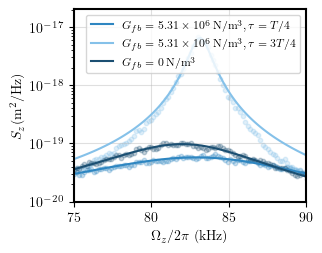

In [97]:
freq = int(1e7)
folder = "../data/delay/batch_0"
#rootFolder = r"D:\Nonlinearity Measurement Week Data\third_day\testes_ganhos\batch_3" #output folder where folders containint the data will be saved
voltageRange = 10 #oscilloscope range
autoRange = 0 #if it equals  1, voltageRange will be ignored and an automatic range will be determined
gainAutoRange = 3 #multiplicative factor that determines the autoRange
autoPSD = 0 #set to 1 to save a single psd upon a specified folder. this assumes "idle_data" folder is precreated inside rootFolder
delay = 5 #amount of seconds between acquisitions (autoPSD only)
Ni = 1 #number of images (autoPSD only)
windows = 10

gain = '8192'

ax = plt.gca()
ax.grid(alpha = 0.4)
ax.figure.set_size_inches(3, 2.5, forward=True)
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
labels = [r'$G_{fb}=5.31\times10^6\,\textrm{N/m}{}^3, \tau=T/4$', r'$G_{fb}=5.31\times10^6\,\textrm{N/m}{}^3, \tau=3T/4$', r'$G_{fb}=0\,\textrm{N/m}{}^3$']
for i, delay in enumerate(["250_0", "875_0"]):
    power, fitted_power, freq, _ = fit_psd('{}/{}_{}'.format(folder, gain, delay), windows=40)
    ax.plot(freq/1000, fitted_power,  color=colors[i], label=labels[i])
    ax.scatter(freq/1000, power, color=colors[i], alpha=0.25, s=10, label='_{}'.format(labels[i]))
    ax.set_xlim([75, 90])
    ax.set_ylim([10**-20, 3*max(power)])
    ax.set_yscale('log')
    ax.set(ylabel=r'$S_z(\textrm{m}{}^2$/Hz)')
    ax.set(xlabel=r'$\Omega_z/2\pi$ (kHz)')
    
power, fitted_power, freq, _ = fit_psd('{}/0_{}_{}'.format(folder, gain, delay), windows=40)
ax.plot(freq/1000, fitted_power,  color=colors[2], label=labels[2])
ax.scatter(freq/1000, power, color=colors[2], alpha=0.25, s=10, label='_{}'.format(labels[2]))
#ax.legend(bbox_to_anchor=(0.5, -0.6), loc='lower center', fontsize=8)
ax.legend(fontsize=8)
plt.savefig('../plots/psds_delay_shifts.png', dpi=300,bbox_inches='tight')
plt.show()